# Evaluate our fine-tuned BERT model

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load keywords and labels

data = {
    "train": pd.concat(
        [
            pd.read_csv("../data/wine_cleaned_train.csv"),
            pd.read_csv("../data/wine_cleaned_val.csv"),
        ]
    ),
    "test": pd.read_csv("../data/wine_cleaned_test.csv"),
}

In [3]:
data_slim = (
    data["train"]
    .groupby("region_variety")
    .apply(lambda x: x.sample(20, random_state=42, replace=True))
    .reset_index(drop=True)
)

In [4]:
data["test"] = (
    data["test"]
    .groupby("region_variety")
    .apply(lambda x: x.sample(10, random_state=42, replace=True))
    .reset_index(drop=True)
)

In [5]:
# Load onnx model and tokenizer

import onnxruntime as rt
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sess = rt.InferenceSession("../models/bert-mini-finetune.onnx")

In [6]:
# Read idx2label json

import json

with open("../models/idx_to_label.json", "r") as f:
    idx2label = json.load(f)

In [7]:
# Get predictions in batches
from tqdm import tqdm


def get_predictions(texts):
    preds = []

    t = tqdm(torch.utils.data.DataLoader(texts, batch_size=256))

    for batch in t:
        inputs = tokenizer(batch, padding=True, return_tensors="pt")
        outputs = sess.run(
            None,
            {
                "input_ids": inputs["input_ids"].numpy(),
                "attention_mask": inputs["attention_mask"].numpy(),
                "token_type_ids": inputs["token_type_ids"].numpy(),
            },
        )
        label_idxes = outputs[0].argmax(axis=1)
        preds.extend([idx2label[idx] for idx in label_idxes])
    return preds

In [8]:
train_preds = get_predictions(data_slim["description"].values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:02<00:00,  1.35s/it]


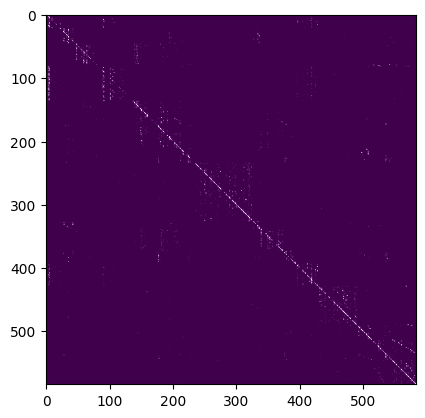

In [9]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


plt.imshow(confusion_matrix(data_slim["region_variety"], train_preds), cmap="PRGn")
plt.savefig("../img/confusion_matrix_bert_train.png")

In [10]:
test_preds = get_predictions(data["test"]["description"].values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:27<00:00,  1.18s/it]


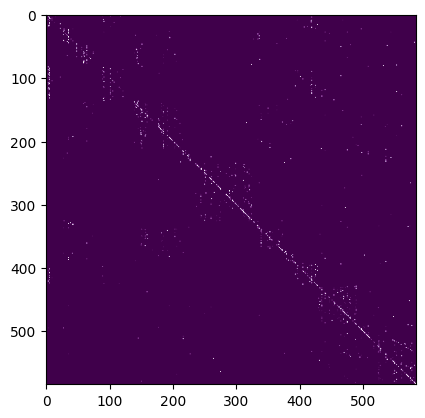

In [11]:
plt.imshow(confusion_matrix(data["test"]["region_variety"], test_preds), cmap="PRGn")
plt.savefig("../img/confusion_matrix_bert_test.png")